In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Network Construction, Novel Target and polypharmacology Interaction Identication

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm
import pickle

def save_graph(G, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(G, f)
    print(f"Graph saved to {file_path}")

def load_graph(file_path):
    print(f"Attempting to load graph from {file_path}")
    with open(file_path, 'rb') as f:
        G = pickle.load(f)
    print(f"Graph successfully loaded from {file_path}")
    return G

def sample_and_preprocess_data(df, sample_ratio=0.01):
    print("Sampling and preprocessing data...")
    sampled_df = pd.DataFrame()
    for entity_type in ['CHEMICAL', 'GENE-Y', 'GENE-N']:
        entity_df = df[(df['entity1_type'] == entity_type) | (df['entity2_type'] == entity_type)]
        sampled_entity = entity_df.sample(frac=sample_ratio, random_state=42)
        sampled_df = pd.concat([sampled_df, sampled_entity])
    sampled_df = sampled_df.drop_duplicates(subset=['article_id', 'entity1', 'entity2'])
    print(f"Sampled {len(sampled_df)} relationships.")
    return sampled_df

def create_graph_from_relationships(df):
    print("Creating graph from relationships...")
    G = nx.Graph()
    for _, row in tqdm(df.iterrows(), total=len(df)):
        entity1, entity2 = row['entity1'], row['entity2']
        entity1_type, entity2_type = row['entity1_type'], row['entity2_type']
        relationship = row['relationship']
        confidence = row['confidence']
        article_id = str(row['article_id'])  # Ensure article_id is a string

        base_weight = 2.0 if ((entity1_type == 'CHEMICAL' and entity2_type in ['GENE-Y', 'GENE-N']) or
                              (entity2_type == 'CHEMICAL' and entity1_type in ['GENE-Y', 'GENE-N'])) else 1.0

        # Check if the edge already exists
        if G.has_edge(entity1, entity2):
            # If it does, append the new article_id to the existing list
            G[entity1][entity2]['article_id'].append(article_id)
        else:
            # If it doesn't, create a new edge with the article_id in a list
            G.add_edge(entity1, entity2, base_weight=base_weight, confidence=confidence,
                       relationship=relationship, weight=base_weight * confidence,
                       article_id=[article_id])

        G.nodes[entity1]['type'] = entity1_type
        G.nodes[entity2]['type'] = entity2_type

    # Ensure all article_id lists are unique
    for u, v, data in G.edges(data=True):
        data['article_id'] = list(set(data['article_id']))

    print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

def calculate_centralities(G):
    print("Calculating centralities...")
    degree_cent = nx.degree_centrality(G)
    pagerank = nx.pagerank(G, weight='weight')
    return degree_cent, pagerank

def identify_novel_targets(G, degree_cent, pagerank, confidence_threshold=0.75, percentile_threshold=90):
    print("Identifying novel targets...")
    novel_targets = []
    for node, data in G.nodes(data=True):
        if data['type'] in ['GENE-Y', 'GENE-N']:
            degree = degree_cent[node]
            pr = pagerank[node]

            # Calculate average confidence from the graph edges
            node_confidences = [G[node][neighbor]['confidence'] for neighbor in G.neighbors(node)]
            avg_confidence = np.mean(node_confidences) if node_confidences else 0

            novelty_score = 2 if data['type'] == 'GENE-N' else 1

            if (pr > np.percentile(list(pagerank.values()), percentile_threshold) and
                degree < np.percentile(list(degree_cent.values()), percentile_threshold) and
                avg_confidence > confidence_threshold):

                combined_score = (pr * novelty_score) / degree if degree != 0 else 0
                novel_targets.append((node, data['type'], degree, pr, avg_confidence, combined_score))

    return pd.DataFrame(novel_targets, columns=['Target', 'Type', 'Degree', 'PageRank', 'AvgConfidence', 'CombinedScore'])

def analyze_polypharmacology(G, degree_cent, pagerank, confidence_threshold=0.7, top_n=100):
    print("Analyzing polypharmacology...")
    poly_candidates = []
    for node, data in G.nodes(data=True):
        if data['type'] == 'CHEMICAL':
            degree = degree_cent[node]
            pr = pagerank[node]

            targets = list(G.neighbors(node))
            num_targets = len(targets)

            if num_targets > 1:
                avg_confidence = np.mean([G[node][target]['confidence'] for target in targets])

                target_types = [G.nodes[target]['type'] for target in targets]

                gene_y_count = sum(1 for t in target_types if t == 'GENE-Y')
                gene_n_count = sum(1 for t in target_types if t == 'GENE-N')

                poly_score = ((gene_y_count + 1.5 * gene_n_count) * pr) / degree if degree != 0 else 0

                if avg_confidence > confidence_threshold:
                    poly_candidates.append((node, num_targets, gene_y_count, gene_n_count, degree, pr, avg_confidence, poly_score))

    poly_df = pd.DataFrame(poly_candidates, columns=['Drug', 'NumTargets', 'GENE-Y_Targets', 'GENE-N_Targets', 'Degree', 'PageRank', 'AvgConfidence', 'PolyScore'])
    return poly_df.nlargest(top_n, 'PolyScore')

In [ ]:
def main(df):
    # Create graph
    #G = create_graph_from_relationships(sampled_df)

    # Load necessary data
    graph_path = '/content/drive/MyDrive/ERP_Code/Network_Construction/relationship_graph.gpickle'
    G = load_graph(graph_path)

    degree_cent, pagerank = calculate_centralities(G)

    novel_targets_df = identify_novel_targets(G, degree_cent, pagerank)
    print("\nTop 10 Novel Target Candidates:")
    print(novel_targets_df.nlargest(10, 'CombinedScore'))

    poly_df = analyze_polypharmacology(G, degree_cent, pagerank)
    print("\nTop 10 Polypharmacology Candidates:")
    print(poly_df.head(10))

    novel_targets_df.to_csv('novel_targets.csv', index=False)
    poly_df.to_csv('polypharmacology_candidates.csv', index=False)

    print("\nAnalysis complete. Results saved to CSV files.")

# Load and preprocess data
df = pd.read_csv('/content/drive/MyDrive/cleaned_data/cleaned_final_relationship_results.csv')
sampled_df = sample_and_preprocess_data(df)
sampled_df.to_csv('/content/drive/MyDrive/ERP_Code/Network_Construction/sampled_relationships.csv', index=False)

sampled_df = pd.read_csv('/content/drive/MyDrive/ERP_Code/Network_Construction/sampled_relationships.csv')
main(sampled_df)

Attempting to load graph from /content/drive/MyDrive/ERP_Code/Network_Construction/relationship_graph.gpickle
Graph successfully loaded from /content/drive/MyDrive/ERP_Code/Network_Construction/relationship_graph.gpickle
Calculating centralities...
Identifying novel targets...

Top 10 Novel Target Candidates:
                                                Target    Type   Degree  \
778                                  β-sandwich domain  GENE-N  0.00001   
779                                              N-SH2  GENE-N  0.00001   
799                                             pG528E  GENE-N  0.00001   
25   cyclic guanosine monophosphate (cGMP) phosphod...  GENE-N  0.00001   
399                                 complexity regions  GENE-N  0.00001   
403                                         OSR domain  GENE-N  0.00001   
493                                            2-OGDDs  GENE-N  0.00001   
605                            cytochrome b6-f complex  GENE-N  0.00001   
631           

# Plot Novel Target Subgraph

In [ ]:
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle

def load_data(novel_targets_path):
    return pd.read_csv(novel_targets_path)

def load_graph(file_path):
    print(f"Attempting to load graph from {file_path}")
    try:
        with open(file_path, 'rb') as f:
            G = pickle.load(f)
        print(f"Graph successfully loaded from {file_path}")
        return G
    except Exception as e:
        print(f"Error loading graph: {str(e)}")
        return None

def analyze_novel_targets(G, novel_targets_df):
    print("Analyzing novel targets...")
    for _, row in tqdm(novel_targets_df.iterrows(), total=len(novel_targets_df)):
        neighbors = list(G.neighbors(row['Target']))
        novel_targets_df.at[_, 'NumNeighbors'] = len(neighbors)
        novel_targets_df.at[_, 'NeighborTypes'] = ', '.join(sorted(set(G.nodes[n]['type'] for n in neighbors)))

        article_ids = set()
        for neighbor in neighbors:
            article_ids.update(G[row['Target']][neighbor].get('article_id', []))
        novel_targets_df.at[_, 'ArticleIDs'] = ', '.join(map(str, sorted(article_ids)))

    return novel_targets_df

def plot_novel_target_subgraph(G, central_node, title, save_path, node_size_factor=300, edge_width_factor=1.2):
    subgraph = nx.ego_graph(G, central_node, radius=1)
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50)
    plt.figure(figsize=(15, 15))

    color_map = {'CHEMICAL': 'lightblue', 'GENE-Y': 'lightgreen', 'GENE-N': 'pink'}
    edge_color_map = {'drug-target': 'blue', 'drug-drug': 'red', 'gene-gene': 'green'}

    node_sizes = {node: (1 + subgraph.degree(node)) * node_size_factor for node in subgraph.nodes()}

    for node_type, color in color_map.items():
        node_list = [node for node in subgraph.nodes() if G.nodes[node]['type'] == node_type]
        nx.draw_networkx_nodes(subgraph, pos, nodelist=node_list, node_color=color,
                               node_size=[node_sizes[node] for node in node_list], alpha=0.8)

    for edge_type, color in edge_color_map.items():
        edge_list = [(u, v) for (u, v) in subgraph.edges()
                     if determine_interaction_type(G.nodes[u]['type'], G.nodes[v]['type'], subgraph[u][v]['base_weight']) == edge_type]
        nx.draw_networkx_edges(subgraph, pos, edgelist=edge_list, edge_color=color, alpha=0.5,
                               width=[subgraph[u][v].get('weight', 1) * edge_width_factor for u, v in edge_list])

    nx.draw_networkx_labels(subgraph, pos, font_size=14, font_weight="bold")

    edge_labels = nx.get_edge_attributes(subgraph, 'relationship')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=12)

    node_legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=node_type,
                                       markerfacecolor=color, markersize=18)
                            for node_type, color in color_map.items()]
    edge_legend_elements = [plt.Line2D([0], [0], color=color, lw=2, label=edge_type)
                            for edge_type, color in edge_color_map.items()]
    plt.legend(handles=node_legend_elements + edge_legend_elements, loc='upper left', fontsize=15)

    plt.title(title, fontsize=22)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Novel target subgraph plot saved to {save_path}")

def determine_interaction_type(node1_type, node2_type, base_weight):
    if base_weight == 2.0:
        return 'drug-target'
    elif 'CHEMICAL' in (node1_type, node2_type):
        return 'drug-drug'
    else:
        return 'gene-gene'

def plot_novel_target_subgraphs(G, novel_targets_df, output_dir, entities=None, top_n=10):
    os.makedirs(output_dir, exist_ok=True)

    if entities is None:
        # Plot top N novel targets
        for _, row in novel_targets_df.head(top_n).iterrows():
        #for _, row in novel_targets_df.nlargest(top_n, 'PageRank').iterrows():
            plot_novel_target_subgraph(G, row['Target'], f"Novel Target: {row['Target']}",
                                       os.path.join(output_dir, f"novel_target_{row['Target']}.png"))
    else:
        # Plot only the specified entities
        for entity in entities:
            if entity in novel_targets_df['Target'].values:
                plot_novel_target_subgraph(G, entity, f"Novel Target: {entity}",
                                           os.path.join(output_dir, f"novel_target_{entity}.png"))
            else:
                print(f"Entity {entity} not found in novel targets.")

In [ ]:
def main():
    # Load the graph
    G = load_graph('/content/drive/MyDrive/ERP_Code/Network_Construction/relationship_graph.gpickle')

    # Check ArticleIDs in the main graph
    print("\nChecking ArticleIDs in the main graph:")
    for u, v, data in list(G.edges(data=True))[:5]:  # Check the first 5 edges
        print(f"Edge {u} - {v}: ArticleIDs: {data.get('article_id', 'Not found')}")

    # Load results from previous analysis
    novel_targets_df = load_data('novel_targets.csv')

    # Further analysis
    novel_targets_df = analyze_novel_targets(G, novel_targets_df)

    # Save updated results
    novel_targets_df.to_csv('/content/drive/MyDrive/ERP_Code/Network_Construction/novel_targets_analyzed.csv', index=False)

    # Plot subgraphs
    # Uncomment one of the following lines based on your preference:

    # Option 1: Plot top 5 novel targets
    plot_novel_target_subgraphs(G, novel_targets_df, '/content/drive/MyDrive/ERP_Code/Network_Construction/novel_target_plots', top_n=10)

    # Option 2: Plot specific novel targets (example)
    # specific_entities = ['Target1', 'Target2', 'Target3']  # Replace with actual target names
    # plot_novel_target_subgraphs(G, novel_targets_df, '/content/drive/MyDrive/ERP_Code/Network_Construction/novel_target_plots', entities=specific_entities)

    print("Analysis complete. Results saved to CSV file and plots generated in 'novel_target_plots' directory.")

if __name__ == "__main__":
    main()

Attempting to load graph from /content/drive/MyDrive/ERP_Code/Network_Construction/relationship_graph.gpickle
Graph successfully loaded from /content/drive/MyDrive/ERP_Code/Network_Construction/relationship_graph.gpickle

Checking ArticleIDs in the main graph:
Edge casticin - PARP: ArticleIDs: ['157310']
Edge casticin - ca: ArticleIDs: ['118681']
Edge casticin - p-p53: ArticleIDs: ['157310']
Edge casticin - p-ATR: ArticleIDs: ['157310']
Edge casticin - MDC1: ArticleIDs: ['157310']
Analyzing novel targets...


100%|██████████| 830/830 [00:00<00:00, 7316.29it/s]


Analysis complete. Results saved to CSV file and plots generated in 'novel_target_plots' directory.


# Plot Polypharmacology Subgraph

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.graph_objects as go
import tqdm
import pickle
import os

def load_graph(file_path):
    print(f"Attempting to load graph from {file_path}")
    try:
        # Try using NetworkX's read_gpickle if available
        if hasattr(nx, 'read_gpickle'):
            G = nx.read_gpickle(file_path)
        else:
            # Fall back to using pickle
            with open(file_path, 'rb') as f:
                G = pickle.load(f)
        print(f"Graph successfully loaded from {file_path}")
        return G
    except Exception as e:
        print(f"Error loading graph: {str(e)}")
        return None

def analyze_polypharmacology(G, poly_df):
    print("Analyzing polypharmacology candidates...")
    total_drugs = len(poly_df)
    for index, row in poly_df.iterrows():
        if index % 100 == 0:
            print(f"Processing drug {index + 1} of {total_drugs}")
        try:
            drug = row['Drug']
            targets = [n for n in G.neighbors(drug) if G.nodes[n]['type'] in ['GENE-Y', 'GENE-N']]
            poly_df.at[index, 'Targets'] = ', '.join(targets)
            poly_df.at[index, 'TargetTypes'] = ', '.join(sorted(set(G.nodes[t]['type'] for t in targets)))

            article_ids = set()
            for target in targets:
                article_ids.update(G[drug][target].get('article_id', []))
            poly_df.at[index, 'ArticleIDs'] = ', '.join(map(str, sorted(article_ids)))
        except KeyError as e:
            print(f"Error processing drug {drug}: {e}")
            poly_df.at[index, 'Targets'] = ''
            poly_df.at[index, 'TargetTypes'] = ''
            poly_df.at[index, 'ArticleIDs'] = ''

    return poly_df

def determine_interaction_type(node1_type, node2_type, base_weight):
    if base_weight == 2.0:
        return 'drug-target'
    elif 'CHEMICAL' in (node1_type, node2_type):
        return 'drug-drug'
    else:
        return 'gene-gene'

def plot_polypharmacology_subgraph(G, central_node, title, save_path, top_n_edges=10,
                                   relationship_filter=None, node_size_factor=300, edge_width_factor=1.2):
    subgraph = nx.ego_graph(G, central_node, radius=1)

    # Filter edges based on weight or confidence
    edges = [(u, v, d) for u, v, d in subgraph.edges(data=True)]
    edges.sort(key=lambda x: x[2].get('weight', 0), reverse=True)
    top_edges = edges[:top_n_edges]

    filtered_subgraph = nx.Graph()
    for u, v, d in top_edges:
        if relationship_filter is None or d.get('relationship') == relationship_filter:
            filtered_subgraph.add_edge(u, v, **d)

    if filtered_subgraph.number_of_edges() == 0:
        print(f"No edges in filtered subgraph for {central_node}")
        return

    # Increase the figure size
    plt.figure(figsize=(20, 20))

    # Adjust the layout to spread out nodes more
    pos = nx.spring_layout(filtered_subgraph, k=0.7, iterations=50)

    color_map = {'CHEMICAL': 'lightblue', 'GENE-Y': 'lightgreen', 'GENE-N': 'pink'}
    edge_color_map = {'drug-target': 'blue', 'drug-drug': 'red', 'gene-gene': 'green'}

    # Adjust node sizes
    node_sizes = {node: (1 + filtered_subgraph.degree(node)) * node_size_factor * 0.8 for node in filtered_subgraph.nodes()}

    for node_type, color in color_map.items():
        node_list = [node for node in filtered_subgraph.nodes() if G.nodes[node].get('type', '') == node_type]
        nx.draw_networkx_nodes(filtered_subgraph, pos, nodelist=node_list, node_color=color,
                               node_size=[node_sizes[node] for node in node_list], alpha=0.8)

    for edge_type, color in edge_color_map.items():
        edge_list = [(u, v) for (u, v) in filtered_subgraph.edges()
                     if determine_interaction_type(G.nodes[u].get('type', ''), G.nodes[v].get('type', ''), filtered_subgraph[u][v].get('base_weight', 1)) == edge_type]
        nx.draw_networkx_edges(filtered_subgraph, pos, edgelist=edge_list, edge_color=color, alpha=0.5,
                               width=[filtered_subgraph[u][v].get('weight', 1) * edge_width_factor for u, v in edge_list])

    nx.draw_networkx_labels(filtered_subgraph, pos, font_size=14, font_weight="bold")

    edge_labels = nx.get_edge_attributes(filtered_subgraph, 'relationship')
    nx.draw_networkx_edge_labels(filtered_subgraph, pos, edge_labels=edge_labels, font_size=12)

    node_legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=node_type,
                                       markerfacecolor=color, markersize=10)
                            for node_type, color in color_map.items()]
    edge_legend_elements = [plt.Line2D([0], [0], color=color, lw=2, label=edge_type)
                            for edge_type, color in edge_color_map.items()]
    plt.legend(handles=node_legend_elements + edge_legend_elements, loc='upper left', fontsize=18)

    plt.title(title, fontsize=25)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Polypharmacology subgraph plot saved to {save_path}")

def plot_selected_polypharmacology_subgraphs(G, poly_df, output_dir, entities=None, top_n=10, top_n_edges=50):
    os.makedirs(output_dir, exist_ok=True)

    if entities is None:
        entities = poly_df['Drug'].head(top_n).tolist()

    for entity in entities:
        if entity in poly_df['Drug'].values:
            # Get the two most common relationship types for this entity
            subgraph = nx.ego_graph(G, entity, radius=1)
            relationships = [d.get('relationship') for u, v, d in subgraph.edges(data=True)]
            common_relationships = [r for r, _ in Counter(relationships).most_common(2)]

            # Plot subgraph for each of the two most common relationship types
            for i, relationship in enumerate(common_relationships):
                plot_polypharmacology_subgraph(G, entity, f"Polypharmacology: {entity} ({relationship})",
                                               os.path.join(output_dir, f"polypharmacology_{entity}_{i+1}.png"),
                                               top_n_edges=top_n_edges, relationship_filter=relationship)
        else:
            print(f"Entity {entity} not found in polypharmacology candidates.")

def create_interactive_network(G, central_node, top_n_edges=50):
    subgraph = nx.ego_graph(G, central_node, radius=20)

    # Filter edges based on weight or confidence
    edges = [(u, v, d) for u, v, d in subgraph.edges(data=True)]
    edges.sort(key=lambda x: x[2].get('weight', 0), reverse=True)
    top_edges = edges[:top_n_edges]

    filtered_subgraph = nx.Graph()
    for u, v, d in top_edges:
        filtered_subgraph.add_edge(u, v, **d)

    pos = nx.spring_layout(filtered_subgraph, k=0.5, iterations=50)

    edge_x = []
    edge_y = []
    for edge in filtered_subgraph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in filtered_subgraph.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(filtered_subgraph.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append(f'{adjacencies[0]} # of connections: {len(adjacencies[1])}')

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f'Interactive Network for {central_node}',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        annotations=[ dict(
                            text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002 ) ],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    return fig

In [ ]:
import pandas as pd
# Load the graph
G = load_graph('/content/drive/MyDrive/ERP_Code/Network_Construction/relationship_graph.gpickle')

# Load results from previous analysis
#poly_df = pd.read_csv('/content/drive/MyDrive/ERP_Code/Network_Construction/polypharmacology_candidates_analyzed.csv')
poly_df = pd.read_csv('polypharmacology_candidates.csv')

# Further analysis
poly_df = analyze_polypharmacology(G, poly_df)

# Save updated results
poly_df.to_csv('/content/drive/MyDrive/ERP_Code/Network_Construction/polypharmacology_candidates_analyzed.csv', index=False)

# Option 1: Plot top 5 polypharmacology candidates
plot_selected_polypharmacology_subgraphs(G, poly_df, '/content/drive/MyDrive/ERP_Code/Network_Construction/poly_plots', top_n=15, top_n_edges=60)

# Option 2: Plot specific polypharmacology candidates (example)
# specific_entities = ['Target1', 'Target2', 'Target3']  # Replace with actual target names
# plot_novel_target_subgraphs(G, poly_df, '/content/drive/MyDrive/ERP_Code/Network_Construction/poly_plots', entities=specific_entities)


Attempting to load graph from /content/drive/MyDrive/ERP_Code/Network_Construction/relationship_graph.gpickle
Graph successfully loaded from /content/drive/MyDrive/ERP_Code/Network_Construction/relationship_graph.gpickle
Analyzing polypharmacology candidates...
Processing drug 1 of 100


In [ ]:
# For interactive visualization:
fig = create_interactive_network(G, 'amino acids', top_n_edges=50)
fig.show()

# Visualisation of Different Metrics

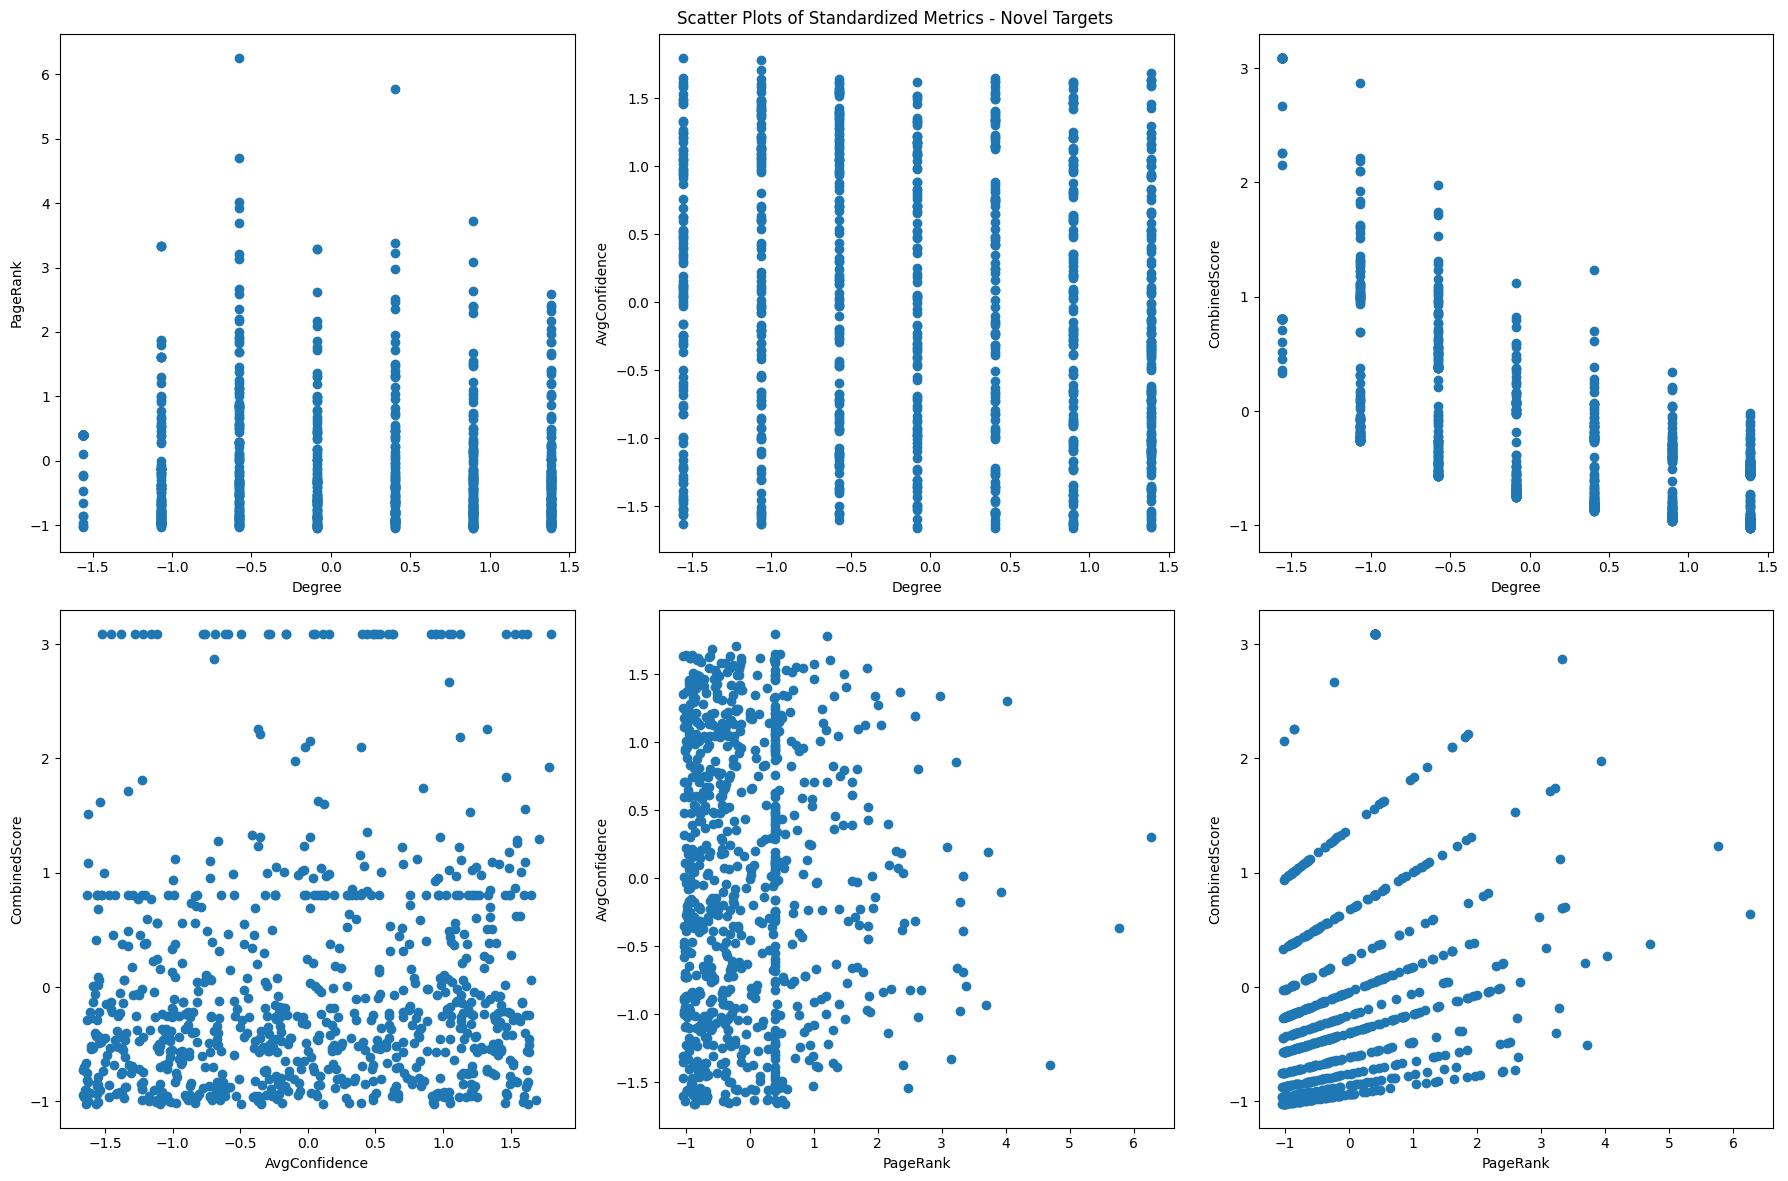

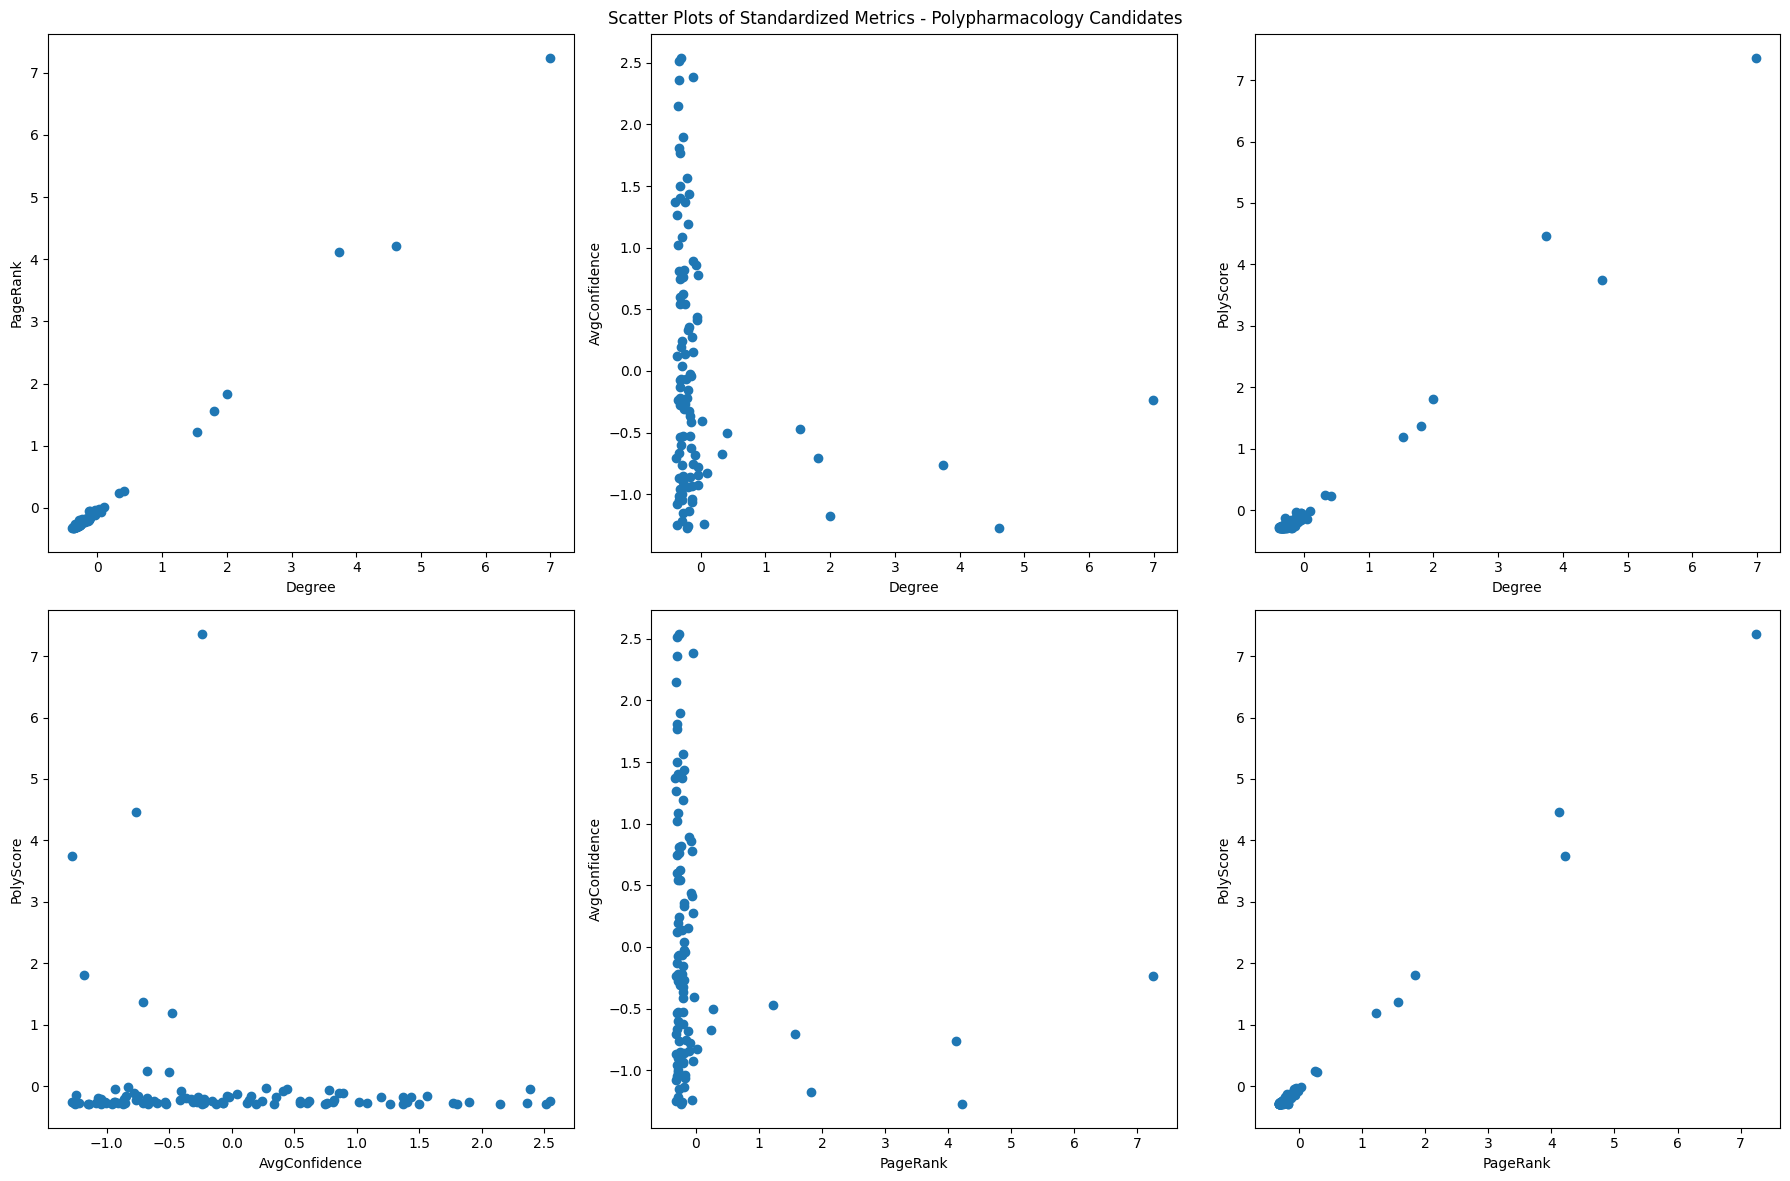

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load the datasets
novel_targets = pd.read_csv('novel_targets.csv')
poly_candidates = pd.read_csv('polypharmacology_candidates.csv')
sampled_df = pd.read_csv('/content/drive/MyDrive/ERP_Code/Network_Construction/sampled_relationships.csv')

# 1. Standardize and create scatter plots
def create_scatter_plots(df, title):
    scaler = StandardScaler()
    columns_to_scale = ['Degree', 'PageRank', 'AvgConfidence', 'CombinedScore' if 'CombinedScore' in df.columns else 'PolyScore']
    scaled_data = pd.DataFrame(scaler.fit_transform(df[columns_to_scale]), columns=columns_to_scale, index=df.index)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Scatter Plots of Standardized Metrics - {title}')

    for i, col1 in enumerate(columns_to_scale):
        for j, col2 in enumerate(columns_to_scale[i+1:], start=i+1):
            ax = axes[i if i < 2 else i-1][j-1 if i < 2 else j-3]
            ax.scatter(scaled_data[col1], scaled_data[col2])
            ax.set_xlabel(col1)
            ax.set_ylabel(col2)

    plt.tight_layout()
    #plt.savefig(f'{title}_scatter_plots.png')
    #plt.close()

create_scatter_plots(novel_targets, 'Novel Targets')
create_scatter_plots(poly_candidates, 'Polypharmacology Candidates')

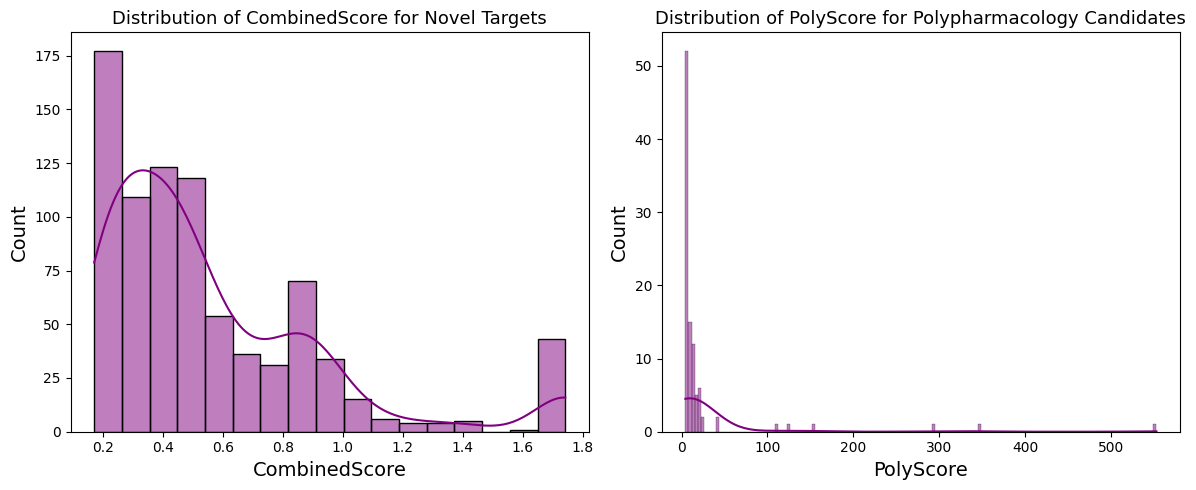

In [ ]:
# 2. Distribution plots of CombinedScore and PolyScore
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(novel_targets['CombinedScore'], kde=True, color = 'purple')
plt.title('Distribution of CombinedScore for Novel Targets',fontsize=13)
plt.xlabel('CombinedScore', fontsize=14)  # Adjust x-label font size
plt.ylabel('Count', fontsize=14)  # Adjust y-label font size

plt.subplot(1, 2, 2)
sns.histplot(poly_candidates['PolyScore'], kde=True, color = 'purple')
plt.title('Distribution of PolyScore for Polypharmacology Candidates', fontsize=13)
plt.xlabel('PolyScore', fontsize=14)  # Adjust x-label font size
plt.ylabel('Count', fontsize=14)  # Adjust y-label font size
plt.tight_layout()
#plt.savefig('score_distributions.png')
#plt.close()

Text(0.5, 1.0, 'CombinedScore Distribution for GENE-N and GENE-Y')

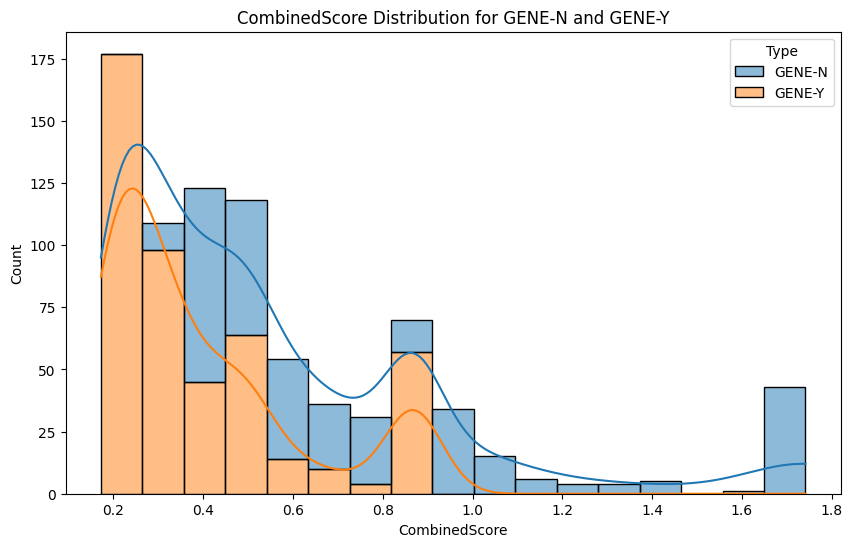

In [ ]:
# 3. CombinedScore distribution for GENE-N and GENE-Y
plt.figure(figsize=(10, 6))
sns.histplot(data=novel_targets, x='CombinedScore', hue='Type', kde=True, multiple='stack', color = 'purple')
plt.title('CombinedScore Distribution for GENE-N and GENE-Y')
#plt.savefig('gene_type_score_distribution.png')
#plt.close()

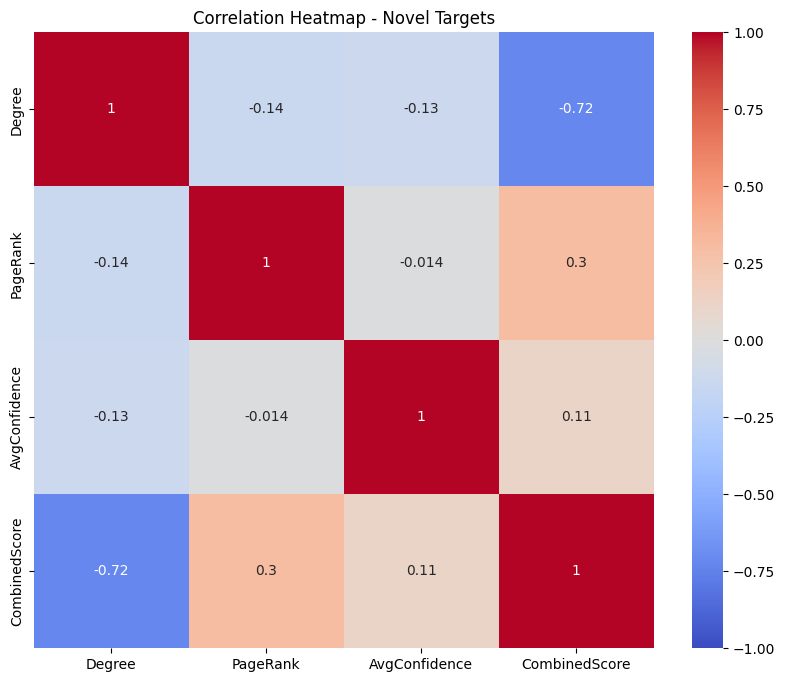

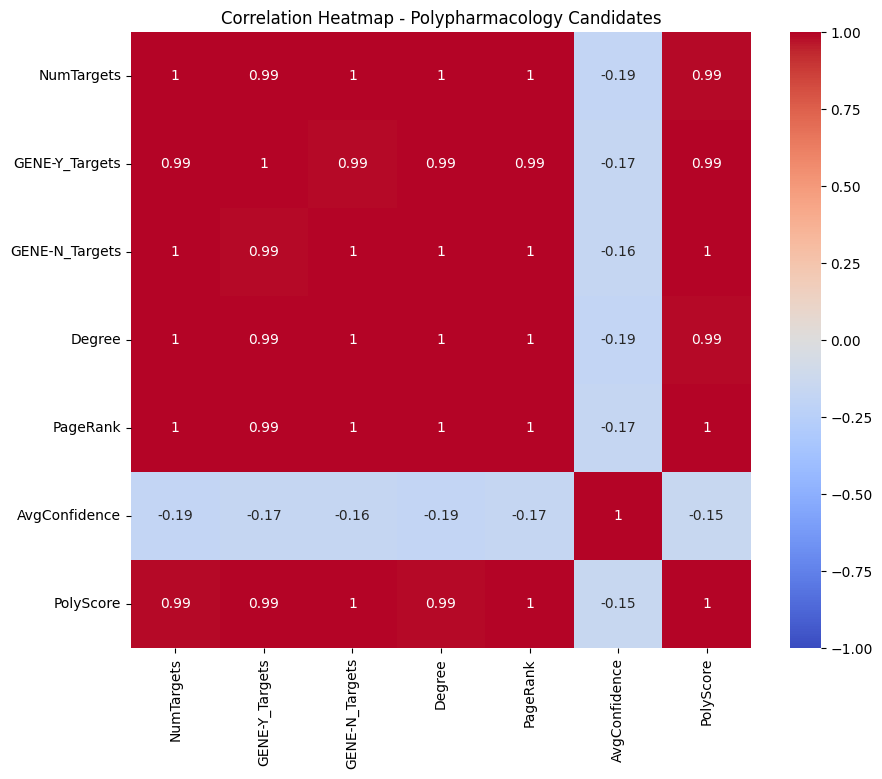

In [ ]:
# 4. Correlation heatmap
import numpy as np

def create_correlation_heatmap(df, title):
    corr = df.select_dtypes(include=[np.number]).corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f'Correlation Heatmap - {title}')
    #plt.savefig(f'{title}_correlation_heatmap.png')
    #plt.close()

create_correlation_heatmap(novel_targets, 'Novel Targets')
create_correlation_heatmap(poly_candidates, 'Polypharmacology Candidates')

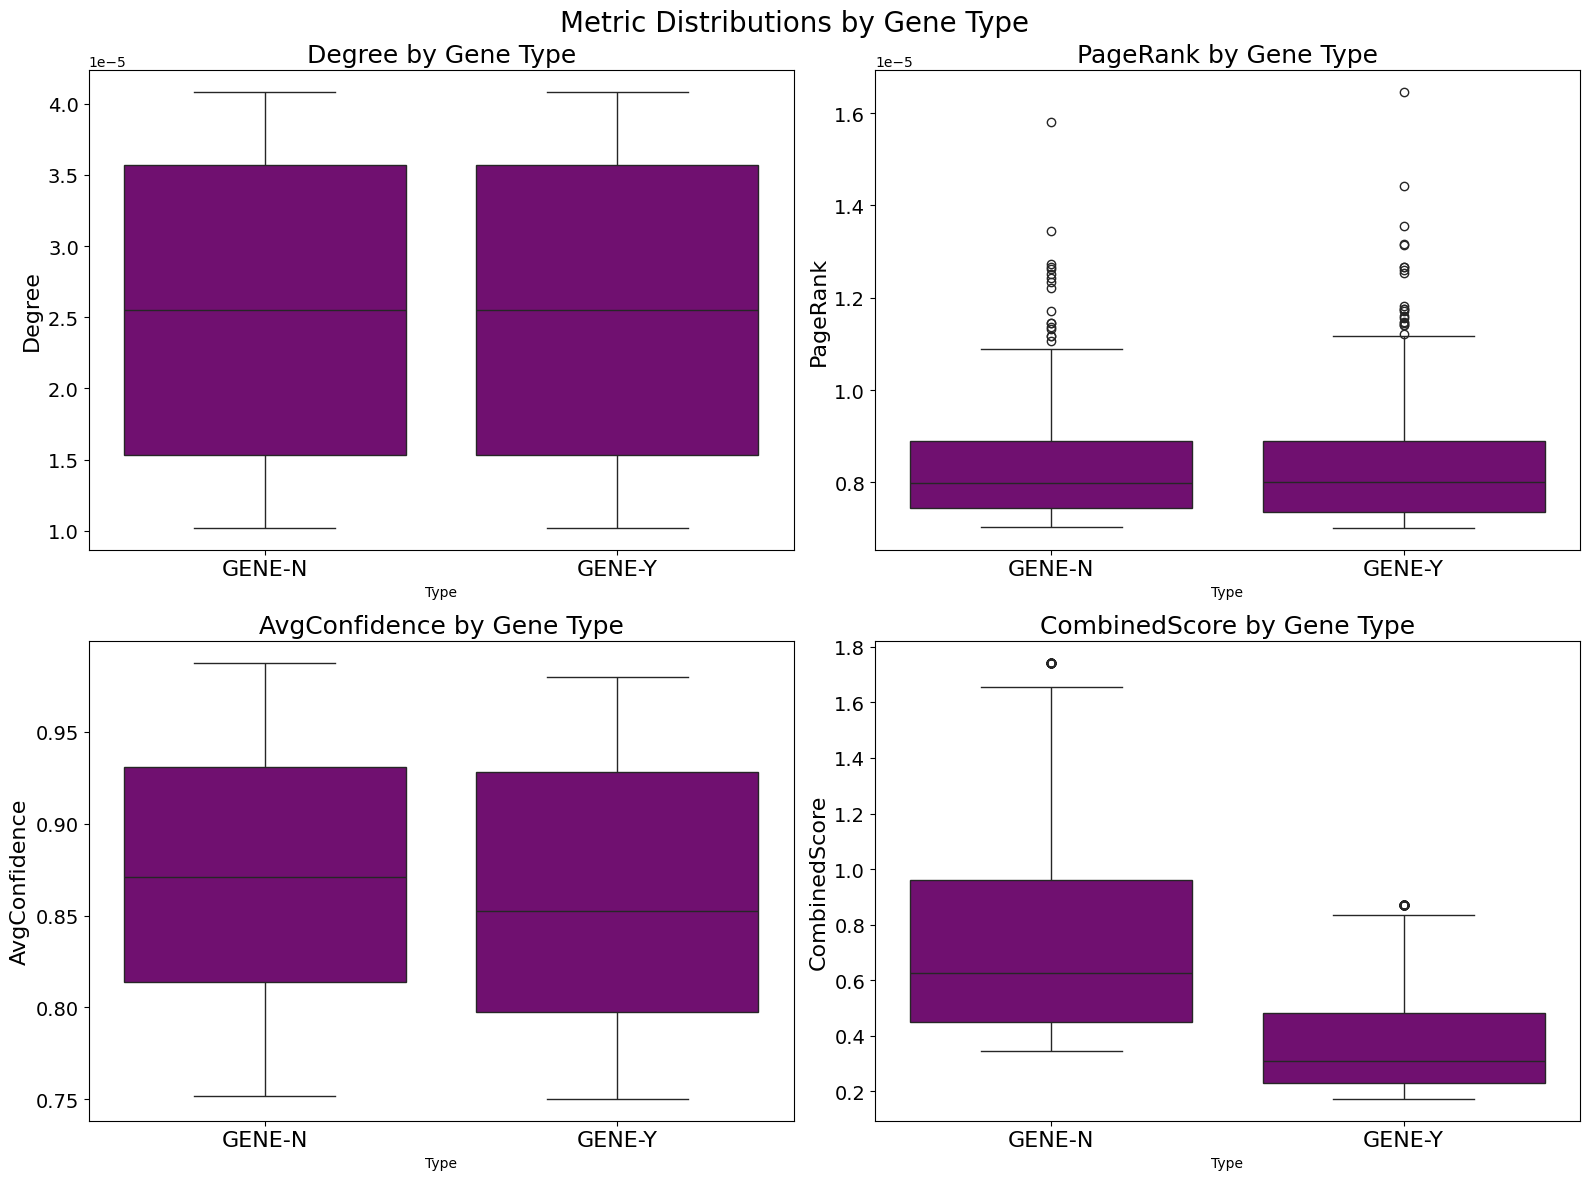

In [ ]:
# 5. Box plots for metrics by Type (for Novel Targets)
metrics = ['Degree', 'PageRank', 'AvgConfidence', 'CombinedScore']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Metric Distributions by Gene Type', fontsize=20)  # Adjust the main title font size

for i, metric in enumerate(metrics):
    sns.boxplot(data=novel_targets, x='Type', y=metric, ax=axes[i//2, i%2], color='purple')
    #axes[i//2, i%2].set_xlabel('Type', fontsize=16)  # Adjust x-label font size
    axes[i//2, i%2].set_ylabel(metric, fontsize=16)  # Adjust y-label font size
    axes[i//2, i%2].set_title(f'{metric} by Gene Type', fontsize=18)  # Adjust individual plot title font size
    axes[i//2, i%2].tick_params(axis='x', labelsize=16)  # Adjust x-tick labels font size
    axes[i//2, i%2].tick_params(axis='y', labelsize=14)  # Adjust x-tick labels font size


plt.tight_layout()
#plt.savefig('novel_targets_metrics_by_type.png')
#plt.close()

Text(0.5, 1.0, 'Number of Targets vs PolyScore')

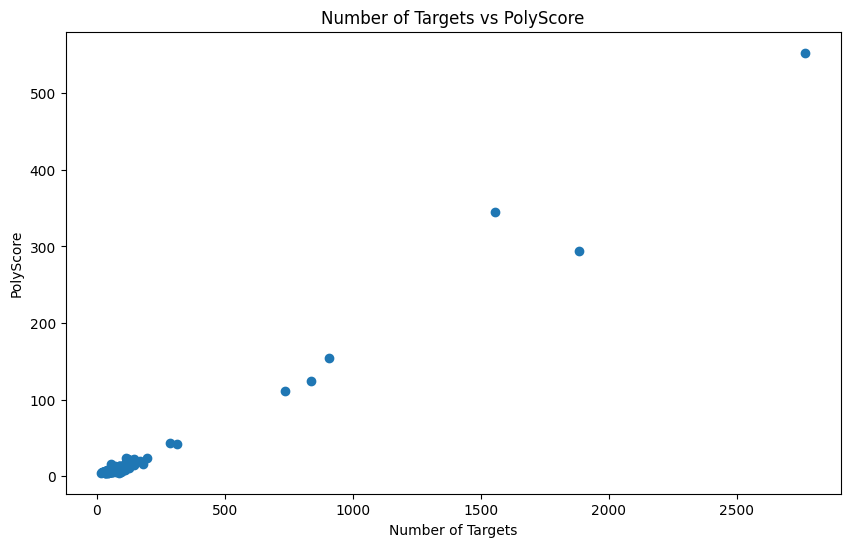

In [ ]:
# 6. Scatter plot of NumTargets vs PolyScore for Polypharmacology Candidates
plt.figure(figsize=(10, 6))
plt.scatter(poly_candidates['NumTargets'], poly_candidates['PolyScore'])
plt.xlabel('Number of Targets')
plt.ylabel('PolyScore')
plt.title('Number of Targets vs PolyScore')
#plt.savefig('numtargets_vs_polyscore.png')
#plt.close()

In [ ]:
# Efficiency comparison
total_entities = len(set(sampled_df['entity1']).union(set(sampled_df['entity2'])))
novel_targets_count = len(novel_targets)
poly_candidates_count = len(poly_candidates)

print(f"Total entities in sample_df: {total_entities}")
print(f"Number of novel targets identified: {novel_targets_count}")
print(f"Number of polypharmacology candidates identified: {poly_candidates_count}")
print(f"Percentage of entities identified as novel targets: {novel_targets_count/total_entities*100:.2f}%")
print(f"Percentage of entities identified as polypharmacology candidates: {poly_candidates_count/total_entities*100:.2f}%")

Total entities in sample_df: 195993
Number of novel targets identified: 830
Number of polypharmacology candidates identified: 100
Percentage of entities identified as novel targets: 0.42%
Percentage of entities identified as polypharmacology candidates: 0.05%


## Counts of Publish Year of Novel Targets and Poly Candidates

In [ ]:
import pandas as pd
from collections import Counter

def count_mentions_per_year(df, entity_column, entities, year_column='PublishedYears'):
    results = {}
    years_range = range(2019, 2024)  # 2019 to 2023

    for entity in entities:
        if entity in df[entity_column].values:
            years = df[df[entity_column] == entity][year_column].iloc[0]
            if pd.notna(years):
                year_counts = Counter(int(year) for year in years.split(', ') if year.strip())
                results[entity] = {year: year_counts.get(year, 0) for year in years_range}
        else:
            print(f"Warning: {entity} not found in the dataframe.")

    return results

def print_mention_counts(results):
    for entity, counts in results.items():
        print(f"\n{entity}:")
        for year, count in counts.items():
            print(f"  {year}: {count} time{'s' if count != 1 else ''}")

# Usage for novel targets
def analyze_novel_targets(df, targets):
    print("Novel Targets Mention Counts:")
    results = count_mentions_per_year(df, 'Target', targets)
    print_mention_counts(results)

# Usage for polypharmacology candidates
def analyze_poly_candidates(df, candidates):
    print("\nPolypharmacology Candidates Mention Counts:")
    results = count_mentions_per_year(df, 'Drug', candidates)
    print_mention_counts(results)

# Example usage:
selected_targets = ['EGFR 19','TP53']  # Replace with actual gene names from your data
analyze_novel_targets(novel_df, selected_targets)

selected_candidates = ['amino acid', 'imatinib']  # Replace with actual drug names from your data
analyze_poly_candidates(poly_df, selected_candidates)

Novel Targets Mention Counts:

EGFR 19:
  2019: 1 time
  2020: 0 times
  2021: 1 time
  2022: 1 time
  2023: 0 times

Polypharmacology Candidates Mention Counts:

amino acid:
  2019: 232 times
  2020: 274 times
  2021: 275 times
  2022: 240 times
  2023: 233 times

imatinib:
  2019: 14 times
  2020: 13 times
  2021: 19 times
  2022: 12 times
  2023: 15 times
